In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Rand reps, model init fixed

In [3]:
import sys
sys.path.append('../../')

import denn.utils as ut

In [4]:
# folder = lambda i: f"/Users/dylanrandle/Downloads/POS_run_gan_053020_seed{i}/val_mse.npy"
# gan_reps = []
# for i in range(5):
#     gan_reps.append(np.load(folder(i)))
# gan_reps = np.vstack(gan_reps)

In [9]:
# gan_reps = np.load('/Users/dylanrandle/Downloads/pos_reps_052620_gan.npy')

gan_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/aca/aca_rand_reps_gan.npy')
kept_runs = [2,5,6,7,9]
gan_reps = gan_reps[kept_runs, :]

l2_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/aca/aca_rand_reps_L2.npy')

l1_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/aca/aca_rand_reps_L1.npy')

huber_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/aca/aca_rand_reps_huber.npy')

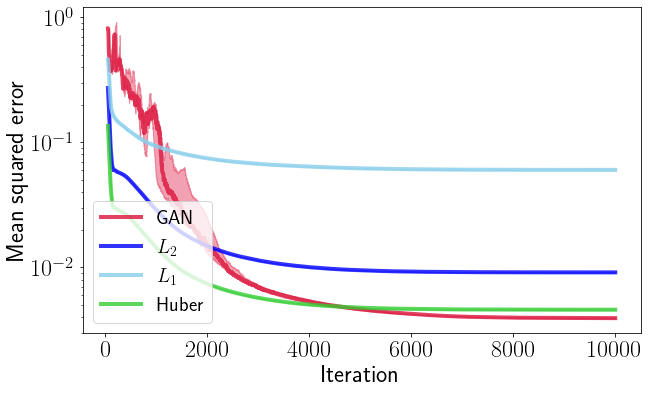

In [12]:
arrs_dict = {"GAN": gan_reps, 
             "$L_2$": l2_reps,
             "$L_1$": l1_reps, 
             "Huber": huber_reps,
#              "RK4": mse*np.ones_like(huber_reps)
            }
ut.plot_reps_results(arrs_dict, fname="aca_rand_reps.png",
                     window=50, figsize=(10,6), pctiles=(25,75), linewidth=4)

In [11]:
print(f"L1 Min: {np.min(l1_reps)}")
print(f"L2 Min: {np.min(l2_reps)}")
print(f"Huber Min: {np.min(huber_reps)}")
print(f"GAN Min: {np.min(gan_reps)}")

L1 Min: 0.06020234525203705
L2 Min: 0.009126380197829584
Huber Min: 0.004592604979635454
GAN Min: 0.0038728368868653114


# Finite Diff

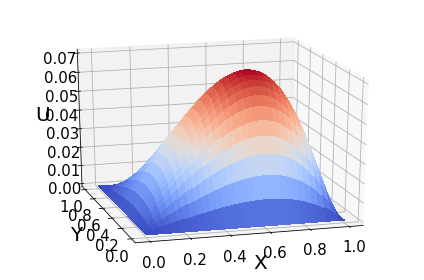

In [15]:

from scipy import sparse
from scipy.sparse.linalg import spsolve
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


# def rhs_func(x, y, M):
#     ###----- Element-wise multiplication -----###
#     g = (20 * np.multiply(np.cos(3*np.pi*X[1:-1,1:-1]), np.sin(2*np.pi*Y[1:-1,1:-1]))).flatten()
#     f = [g[i::M-2] for i in range(M-2)] # Extracts only the inner values
#     f = np.asarray(f).flatten() # Flattens into a ((M-2)**2, ) array
#     return f

def rhs_func(x, y, M):
    ###----- Element-wise multiplication -----###
    x, y = X[1:-1,1:-1], Y[1:-1,1:-1]
    g = -(2*x*(y-1)*(y - 2*x + x*y + 2)*np.exp(x-y)).flatten()
    f = [g[i::M-2] for i in range(M-2)] # Extracts only the inner values
    f = np.asarray(f).flatten() # Flattens into a ((M-2)**2, ) array
    return f


def bc_dirichlet(x, y, m):
    ###----- Initializes boundary condition values -----###
    lBC = np.zeros(M) # Y[:,0]**2
    leftBC = lBC[1:M-1]
    
    rBC = np.zeros(M) # np.ones((M,1)).flatten()
    rightBC = rBC[1:M-1]
    
    tBC = np.zeros(M) #X[0,:]**3
    topBC = tBC[1:M-1]
    
    bBC = np.zeros(M) #np.ones((1,M)).flatten()
    bottomBC = bBC[1:M-1]
    
    ###----- Creates a ((M-2)**2, ) array of zeros -----###
    g1 = np.zeros(((M-2)**2, 1)).flatten()
    
    ###----- Fills in the top BC (red circles on p. 21) -----###
    for i in range(M-2):
        g1[(M-2)*i] = topBC[i] 
    
    ###----- Fills in the bottom BC (blue circles on p. 21) -----###
    for j in range(M-2):
        g1[(M-2)*(j+1)-1] = bottomBC[j]
    
    ###----- Fills in the left BC (top orange circle on p. 21) -----###
    k1 = np.zeros((len(leftBC),1))
    k1[0] = 1.0
    leftBCk = sparse.kron(k1,leftBC).toarray().flatten()
    
    ###----- Fills in the right BC (bottom orange circle on p. 21) -----###
    k2 = np.zeros((len(rightBC),1))
    k2[-1] = 1.0
    rightBCk = sparse.kron(k2,rightBC).toarray().flatten()
    
    ###----- Collects all -----###
    g = g1 + leftBCk + rightBCk
    
    return [g, lBC, tBC, rBC, bBC]
    

def generate_lhs_matrix(M, hx, hy):
    
    alpha = hx**2/hy**2

    main_diag = 2 * (1 + alpha) * np.ones((M - 2, 1)).ravel()
    off_diag = -1 * np.ones((M - 2, 1)).ravel()
    
    a = main_diag.shape[0]

    diagonals = [main_diag, off_diag, off_diag]

    B = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
    
    C = sparse.diags([-1*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
        
    e1 = sparse.eye(M-2).toarray()
    
    A1 = sparse.kron(e1,B).toarray()
    
    e2 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M-2,M-2)).toarray()
    
    A2 = sparse.kron(e2,C).toarray()
    
    mat = A1 + A2

    return mat


###========================================###

M = 32
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

x1 = np.linspace(x0, xf, M)
y1 = np.linspace(y0, yf, M)

###----- Generates a grid ----###
X, Y = np.meshgrid(x1, y1)

###----- The right hand side function ----###
frhs = rhs_func(X, Y, M)

###----- Boundary conditions ----###
fbc = bc_dirichlet(X, Y, M)

rhs = frhs*(hx**2) + fbc[0]

A = generate_lhs_matrix(M, hx, hy)

###----- Solves A*x=b --> x=A\b ----###
V = np.linalg.solve(A,rhs)

###----- Reshapes the 1D array into a 2D array -----###
V = V.reshape((M-2, M-2)).T

###----- Fills in boundary values for Dirichlet BC -----###
U = np.zeros((M,M))

U[1:M-1, 1:M-1] = V
U[:,0] = fbc[1]
U[0,:] = fbc[2]
U[:,M-1] = fbc[3]
U[M-1,:] = fbc[4]

###----- Plots -----###
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

###----- Static image -----###
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
plt.tight_layout()
ax.view_init(20, -106)
plt.show()


## #----- Rotate the axes and update
## for angle in range(0, 360):
##    ax.view_init(20, angle)
##    plt.draw()
##    plt.pause(.001)
#

In [16]:
U.shape

(32, 32)

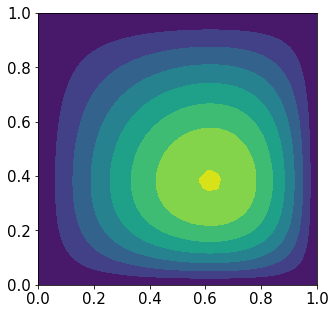

In [31]:
plt.figure(figsize=(5,5))
plt.contourf(X, Y, U)

In [27]:
def anal_sol(x, y):
    return x*(1-x)*y*(1-y)*np.exp(x-y)

In [28]:
U_an = anal_sol(X, Y)

In [29]:
U_an.shape

(32, 32)

In [30]:
np.mean((U - U_an)**2)

3.248673419947458e-10